In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from parser import Parser

/Users/lzl/Documents/CMU/DS/project 2/pds-proj2/parser.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out["price"] = [(high+low)/2 for high,low in zip(out["high"], out["low"])]


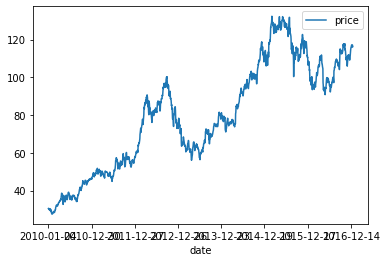

In [3]:
parser = Parser()
apple = parser.get("AAPL")
apple.plot()

In [4]:
# splitting into train and test sets

split = int(apple.shape[0]*0.7)
train, test = apple.iloc[:split, :], apple.iloc[split:, :]

# Autoregression model

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


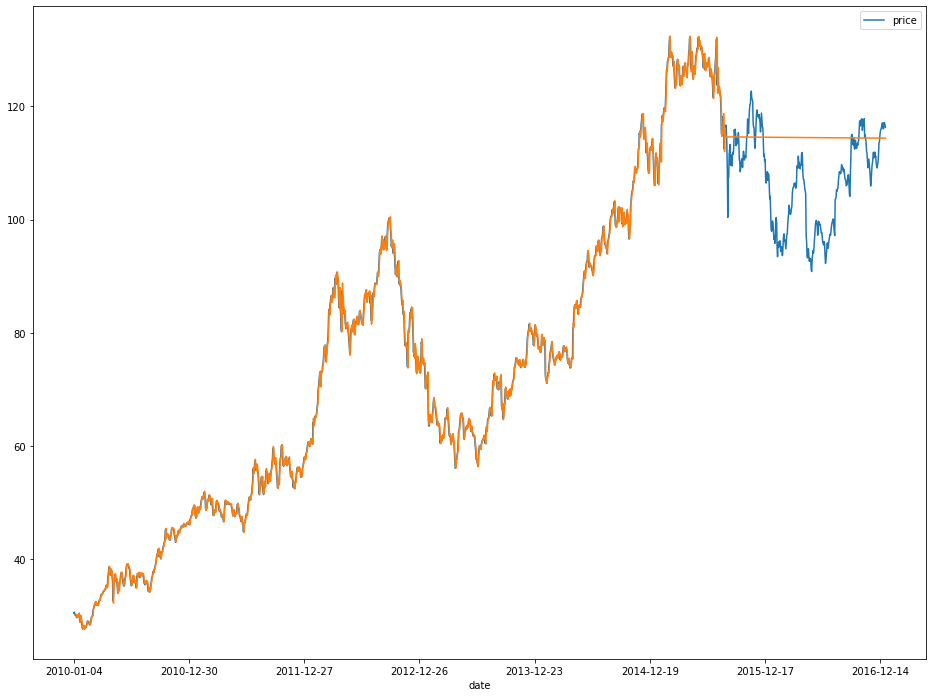

In [5]:
# !pip install statsmodels # on windows
# !pip3 install statsmodels # on mac

from statsmodels.tsa.ar_model import AutoReg

start = int(apple.shape[0]*0.8)

model = AutoReg(apple, lags=5).fit()
pred = model.predict(start=0, dynamic=start)

# pred = pd.Series([0 for i in range(start)]).append(pred)

apple.plot(figsize=(16,12))
pred.plot()


# ARIMA Model

In [6]:
from statsmodels.tsa.arima_model import ARIMA

arima_model = ARIMA(train, order=(1,1,1))
arima_model_fit = arima_model.fit(disp=0)

arima_model_fit.summary()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.price   No. Observations:                 1232
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1696.760
Method:                       css-mle   S.D. of innovations              0.959
Date:                Sat, 02 May 2020   AIC                           3401.520
Time:                        18:19:08   BIC                           3421.985
Sample:                             1   HQIC                          3409.219
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0709      0.033      2.170      0.030       0.007       0.135
ar.L1.D.price    -0.0360      0.120     -0.301      0.764      -0.270       0.199
ma.L1.D.price     0.2392      0.115      2.073      0.038       0.013       0.465
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -27.8039           +0.0000j           27.8039            0.5000
MA.1           -4.1814           +0.0000j            4.1814            0.5000
-----------------------------------------------------------------------------
"""

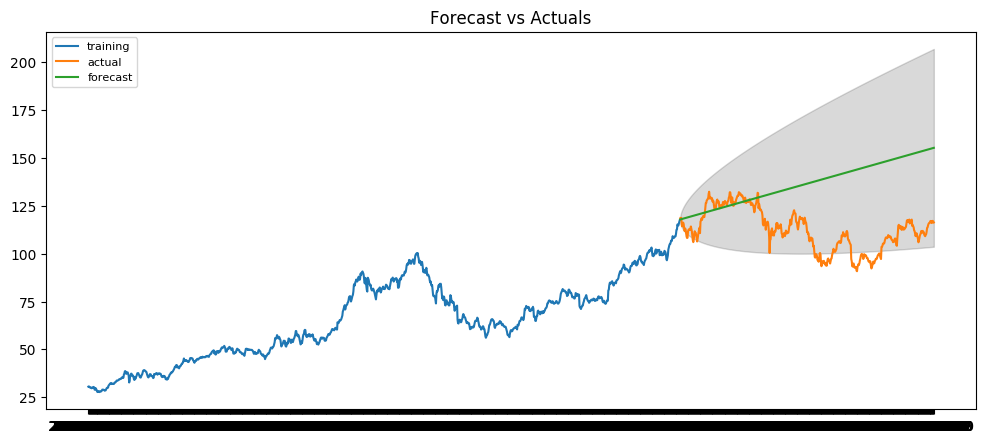

In [7]:
fc, se, conf = arima_model_fit.forecast(test.shape[0], alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Classification
use n last prices to predict whether next price tick will be higher or lower than previous one

In [8]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

WINDOW = 50

x = []
y = []
for i in range(WINDOW, len(apple.values)):
    xv = apple["price"].values[i-WINDOW:i]
    yv = apple["price"].values[i]
    x.append(xv)
    
    if yv < xv[-1]:
        y.append(0)
    else:
        y.append(1)
    
x = pd.DataFrame(x)

Scalers = [
    ("standard scaler", StandardScaler),
    ("min max scaler", MinMaxScaler),
    ("robust scaler", RobustScaler),
    ("max ab scaler", MaxAbsScaler)
]

Models = [
    ("Naive bayes", BernoulliNB),
    ("logistic regresssion", LogisticRegression),
    ("decision tree", DecisionTreeClassifier),
    ("random forest", RandomForestClassifier),
    ("support vector machine", LinearSVC)
]

for scaler_name, Scaler in Scalers:

    print("="*100)
    print("scaler used:", scaler_name)
    print("="*100)
    print()
    
    for model_name, Model in Models:

        scaler = Scaler()
        x_scaled = scaler.fit_transform(x)
        x_train, x_test, y_train, y_test = train_test_split(x_scaled,y)


        model = Model()
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        print(f"{model_name} accuracy score:", accuracy_score(y_pred, y_test))
        print(f"{model_name} precision score:", precision_score(y_pred, y_test))
        print(f"{model_name} recall score:", recall_score(y_pred, y_test))
        print(f"{model_name} f1 score:", f1_score(y_pred, y_test))
        print()




scaler used: standard scaler

Naive bayes accuracy score: 0.5
Naive bayes precision score: 0.5135135135135135
Naive bayes recall score: 0.5181818181818182
Naive bayes f1 score: 0.5158371040723982

logistic regresssion accuracy score: 0.5280373831775701
logistic regresssion precision score: 0.7593360995850622
logistic regresssion recall score: 0.5596330275229358
logistic regresssion f1 score: 0.6443661971830986

decision tree accuracy score: 0.5654205607476636
decision tree precision score: 0.6157024793388429
decision tree recall score: 0.6157024793388429
decision tree f1 score: 0.6157024793388429



/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


random forest accuracy score: 0.5420560747663551
random forest precision score: 0.6359447004608295
random forest recall score: 0.5411764705882353
random forest f1 score: 0.5847457627118644

support vector machine accuracy score: 0.5794392523364486
support vector machine precision score: 0.7711864406779662
support vector machine recall score: 0.5909090909090909
support vector machine f1 score: 0.6691176470588236

scaler used: min max scaler

Naive bayes accuracy score: 0.5397196261682243
Naive bayes precision score: 0.9912663755458515
Naive bayes recall score: 0.5379146919431279
Naive bayes f1 score: 0.6973886328725037

logistic regresssion accuracy score: 0.5584112149532711
logistic regresssion precision score: 0.9831223628691983
logistic regresssion recall score: 0.5574162679425837
logistic regresssion f1 score: 0.7114503816793892



/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


decision tree accuracy score: 0.6004672897196262
decision tree precision score: 0.654320987654321
decision tree recall score: 0.6463414634146342
decision tree f1 score: 0.6503067484662577

random forest accuracy score: 0.5584112149532711
random forest precision score: 0.6666666666666666
random forest recall score: 0.5735849056603773
random forest f1 score: 0.6166328600405679

support vector machine accuracy score: 0.572429906542056
support vector machine precision score: 0.8776371308016878
support vector machine recall score: 0.574585635359116
support vector machine f1 score: 0.6944908180300501

scaler used: robust scaler

Naive bayes accuracy score: 0.5163551401869159
Naive bayes precision score: 0.49122807017543857
Naive bayes recall score: 0.5517241379310345
Naive bayes f1 score: 0.5197215777262181

logistic regresssion accuracy score: 0.5700934579439252
logistic regresssion precision score: 0.9071729957805907
logistic regresssion recall score: 0.5702917771883289
logistic regresssio

/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


decision tree accuracy score: 0.5747663551401869
decision tree precision score: 0.5914893617021276
decision tree recall score: 0.6177777777777778
decision tree f1 score: 0.6043478260869565

random forest accuracy score: 0.5116822429906542
random forest precision score: 0.5466666666666666
random forest recall score: 0.5347826086956522
random forest f1 score: 0.5406593406593406

support vector machine accuracy score: 0.5817757009345794
support vector machine precision score: 0.8975409836065574
support vector machine recall score: 0.5871313672922251
support vector machine f1 score: 0.7098865478119935



/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
